In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import torch
import warnings
from datasets import Dataset
from datetime import datetime
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.nn import CrossEntropyLoss
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

os.chdir("../../")
random.seed(42)

In [2]:
risk_levels = ["Negligible", "Low", "Medium", "High", "Severe"]

### Load data

In [3]:
# Load data
train = pd.read_csv('data/processed/train_esg_shortened.csv')
train = train[train.transcript_esg.apply(lambda t: isinstance(t, str))]
test = pd.read_csv('data/processed/test_esg_shortened.csv')
test = test[test.transcript_esg.apply(lambda t: isinstance(t, str))]

In [4]:
train.head()

,symbol,year,quarter,transcript_esg,esg_score,esg_risk_level
0,A,2022,1,thank emily welcome everyone agilents conferen...,15.0,Low
1,A,2022,3,thank hannah welcome everyone agilents confere...,15.0,Low
2,AAPL,2022,1,good day welcome apple q fy earnings conferenc...,17.0,Low
3,AAPL,2022,2,good day welcome apple q fy earnings conferenc...,17.0,Low
4,AAPL,2022,3,good day welcome apple q fy earnings conferenc...,17.0,Low


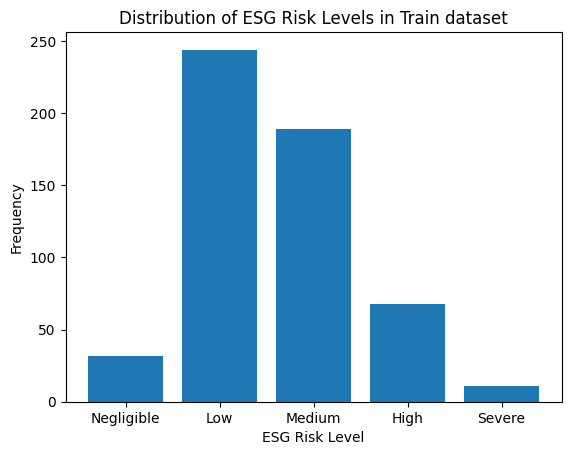

In [5]:
# Plotting the distribution of 'esg_risk_level'
plt.figure()
plt.bar(x=risk_levels, height=[list(train['esg_risk_level']).count(l) for l in risk_levels])
plt.title('Distribution of ESG Risk Levels in Train dataset')
plt.xlabel('ESG Risk Level')
plt.ylabel('Frequency')
plt.show()

### Load model

In [6]:
BASE_MODEL = "google-bert/bert-base-uncased"
LEARNING_RATE = 5e-5
MAX_LENGTH = 512
BATCH_SIZE = 12
EPOCHS = 32

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL,
    id2label={k:k for k in range(len(risk_levels))},
    label2id={k:k for k in range(len(risk_levels))}
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Prepare datasets

In [8]:
def get_dataset(df):
    ds = tokenizer(list(df["transcript_esg"]), truncation=True, padding="max_length", max_length=MAX_LENGTH)
    ds["labels"] = list(df["esg_risk_level"].apply(risk_levels.index))
    return ds

train = train.sample(frac=1, random_state=42)
dataset_train = Dataset.from_dict(get_dataset(train[:int(train.shape[0] * 0.8)]))
dataset_val = Dataset.from_dict(get_dataset(train[int(train.shape[0] * 0.8):]))

In [9]:
dataset_train

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 435
})

### Prepare for training

In [10]:
timestamp = datetime.now().strftime("%y%m%d_%H%M")
training_args = TrainingArguments(
    output_dir=f"checkpoints/bert_finetuned_{timestamp}/",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    greater_is_better=False,
    save_total_limit=2,
    load_best_model_at_end=True,
    weight_decay=0.01,
    report_to="none",
)

In [11]:
class_weights = torch.tensor([(1.0 / train['esg_risk_level'].value_counts()[l])**0.8 for l in risk_levels], dtype=torch.float)  # Explicitly define as float
class_weights = class_weights / class_weights.sum() * len(risk_levels)
loss_fn = CrossEntropyLoss(weight=class_weights.to(torch.device("cuda")))

class ClassificationTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0]
        loss=loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = (labels == predictions).mean()
    return {"accuracy": acc}

In [13]:
trainer = ClassificationTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    compute_metrics=compute_metrics,
)

### Training

In [14]:
warnings.filterwarnings("ignore")
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.561600,1.815597,0.128440
2,1.553500,1.819474,0.458716
3,1.518800,1.793126,0.467890
4,1.437000,1.610898,0.385321
5,1.156000,1.166332,0.477064
6,0.865100,1.153374,0.633028
7,0.559200,0.810706,0.761468
8,0.274200,0.633542,0.788991
9,0.120600,0.895052,0.798165
10,0.031900,0.536643,0.853211


TrainOutput(global_step=608, training_loss=0.2861673506221881, metrics={'train_runtime': 448.4713, 'train_samples_per_second': 31.039, 'train_steps_per_second': 1.356, 'total_flos': 3662604543098880.0, 'train_loss': 0.2861673506221881, 'epoch': 32.0})

### Evaluation 

In [15]:
dataset_test = get_dataset(test)
dataset_test = Dataset.from_dict(dataset_test)
dataset_test

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 138
})

In [16]:
trainer.eval_dataset = dataset_test
warnings.filterwarnings("ignore")
trainer.evaluate()

{'eval_loss': 3.2551281452178955,
 'eval_accuracy': 0.5507246376811594,
 'eval_runtime': 1.3287,
 'eval_samples_per_second': 103.859,
 'eval_steps_per_second': 4.516,
 'epoch': 32.0}

### Save model

In [19]:
# trainer.model.save_pretrained("models/bert_for_risk_level_prediction")

### Load model

In [7]:
# model = AutoModelForSequenceClassification.from_pretrained(
#     "models/bert_for_risk_level_prediction", 
#     id2label={k:k for k in range(len(risk_levels))},
#     label2id={k:k for k in range(len(risk_levels))},
# )
# model.to("cuda")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Save model inferencing results

In [8]:
BATCH_SIZE = 8

def get_results(df):
    
    nb_batches = len(df) // BATCH_SIZE + int(len(df) % BATCH_SIZE > 0)
    esg_risk_level_pred = []

    for i in range(nb_batches):
        input_texts = list(df[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["transcript_esg"])
        encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_tensors="pt").to("cuda")
        logits = model(**encoded).logits
        esg_risk_level_pred += [risk_levels[idx] for idx in torch.argmax(logits, axis=1)]
    
    df["esg_risk_level_pred"] = esg_risk_level_pred
    
    return df

In [9]:
get_results(train)

,symbol,year,quarter,transcript_esg,esg_score,esg_risk_level,esg_risk_level_pred
0,A,2022,1,thank emily welcome everyone agilents conferen...,15.0,Low,Low
1,A,2022,3,thank hannah welcome everyone agilents confere...,15.0,Low,Low
2,AAPL,2022,1,good day welcome apple q fy earnings conferenc...,17.0,Low,Low
3,AAPL,2022,2,good day welcome apple q fy earnings conferenc...,17.0,Low,Low
4,AAPL,2022,3,good day welcome apple q fy earnings conferenc...,17.0,Low,Low
...,...,...,...,...,...,...,...
542,WMT,2023,3,followed questionandanswer session turn call d...,25.0,Medium,Medium
543,YUM,2022,1,welcome q yum brand earnings conference call n...,21.0,Medium,Medium
544,YUM,2022,2,get started would like remind conference call ...,21.0,Medium,Medium
545,ZTS,2022,1,thank operator good morning everyone welcome z...,18.0,Low,Low


In [11]:
accuracy_score(train.esg_risk_level, train.esg_risk_level_pred)

0.9705882352941176

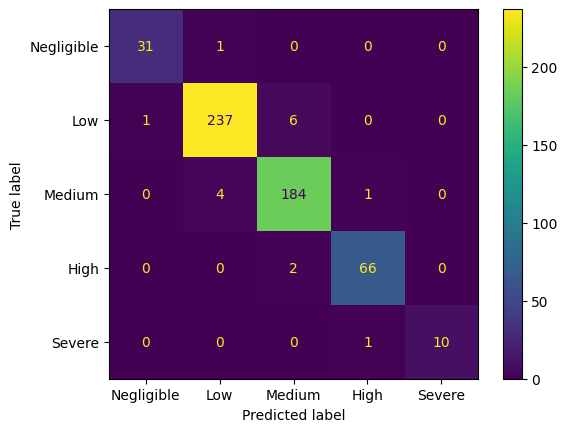

In [16]:
cm = confusion_matrix(train.esg_risk_level, train.esg_risk_level_pred, labels=risk_levels)
cm = ConfusionMatrixDisplay(cm, display_labels=risk_levels)
cm.plot()
plt.show()

In [17]:
get_results(test)

,symbol,year,quarter,transcript_esg,esg_score,esg_risk_level,esg_risk_level_pred
0,ADP,2022,1,call reference nongaap financial measures beli...,14.0,Low,Low
1,ADP,2022,1,call reference nongaap financial measures beli...,14.0,Low,Low
2,ADSK,2022,1,addition replay call available autodeskcominve...,16.0,Negligible,Low
3,ADSK,2022,3,addition replay call available autodeskcominve...,16.0,Negligible,Low
4,ADSK,2022,4,addition replay call available autodeskcominve...,16.0,Negligible,Low
...,...,...,...,...,...,...,...
133,VRTX,2022,2,reshma kewalramani vertexs ceo president stuar...,23.0,Medium,Medium
134,VRTX,2022,3,reshma kewalramani vertexs ceo president stuar...,23.0,Medium,Medium
135,XRAY,2022,1,begin let start im excited took role interim c...,16.0,Negligible,Medium
136,XYL,2022,2,good morning everyone welcome xylems second qu...,16.0,Negligible,Medium


In [18]:
accuracy_score(test.esg_risk_level, test.esg_risk_level_pred)

0.5507246376811594

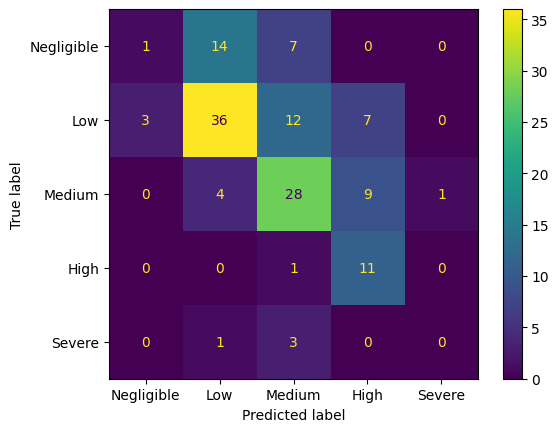

In [19]:
cm = confusion_matrix(test.esg_risk_level, test.esg_risk_level_pred, labels=risk_levels)
cm = ConfusionMatrixDisplay(cm, display_labels=risk_levels)
cm.plot()
plt.show()

In [20]:
# train.to_csv(f"results/bert_finetuned/bert_for_risk_level_classification_train.csv")
# test.to_csv(f"results/bert_finetuned/bert_for_risk_level_classification_test.csv")